# Non centered Multilevel slopes

In [2]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = (train[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()
test['log_sales_price_std'] = (test[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()


In [3]:
def standardise_predictor(column):
    std_pred_train = (train[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    std_pred_test = (test[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    
    return std_pred_train, std_pred_test

train['log_lot_area_z'] , test['log_lot_area_z'] = standardise_predictor(column = 'log_lot_area')
train['BedroomAbvGr_z'] , test['BedroomAbvGr_z'] = standardise_predictor(column = 'BedroomAbvGr')
train['OverallCond_z'] , test['OverallCond_z'] = standardise_predictor(column = 'OverallCond')
train['OverallQual_z'] , test['OverallQual_z'] = standardise_predictor(column = 'OverallQual')
train['GrLivArea_z'] , test['GrLivArea_z'] = standardise_predictor(column = 'GrLivArea')
train['1stFlrSF_z'], test['1stFlrSF_z'] = standardise_predictor(column = '1stFlrSF')
train['2ndFlrSF_z'], test['2ndFlrSF_z'] = standardise_predictor(column = '2ndFlrSF')

X = pd.concat([train['BedroomAbvGr_z'],
               train['OverallCond_z'], 
               train['OverallQual_z'],
               train['GrLivArea_z'],
              train['1stFlrSF_z'],
              train['2ndFlrSF_z']],
               axis = 1)

X_test = pd.concat([test['BedroomAbvGr_z'],
                    test['OverallCond_z'], 
                    test['OverallQual_z'],
                    test['GrLivArea_z'],
                    test['1stFlrSF_z'],
                    test['2ndFlrSF_z']],
                   axis = 1)

## Load and simulate fake data

In [4]:
# Import multilevel model
nc_multilevel_slopes = pystan.StanModel(file = '../../models/nc_multilevel_slopes_extra.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ec4400a770804022f8ce18cbf9c2b7d5 NOW.


In [5]:
# Set parameters
alpha_sd = 0.01
beta_sd = 0.1
beta_vec_sd = 0.1
sigma_sd = 1
sigma_nh_sd = 1
Rho_eta =  4

In [6]:
nc_mls_data_check = dict(N = len(train),
                         N_test = len(test),
                         P = len(X.columns),
                         P_test = len(X_test.columns),
                         X = X,
                         X_test = X_test,
                         log_sales_price = train['log_sales_price_std'],
                         log_lot_area = train['log_lot_area_z'],
                         neighbourhood = train['neighbourhood'],
                         N_neighbourhood = len(train['Neighborhood'].unique()),
                         log_lot_area_test = test['log_lot_area_z'],
                         neighbourhood_test = test['neighbourhood'],
                         alpha_sd = alpha_sd,
                         beta_sd = beta_sd,
                         beta_vec_sd = beta_vec_sd,
                         sigma_sd = sigma_sd,
                         sigma_nh_sd = sigma_nh_sd,
                         Rho_eta =  Rho_eta,
                         run_estimation = 0)

fit_nc_mls_check = nc_multilevel_slopes.sampling(data=nc_mls_data_check)
df_nc_mls_check = fit_nc_mls_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Traceplots

In [ ]:
# Inspect model fit
az.plot_trace(fit_nc_mls_check, 
              var_names=["alpha_nh", "beta_nh", 'beta', "sigma", 'Rho'], 
              compact = True, 
              chain_prop = 'color');

## Prior predcitive checks

In [ ]:
nc_mls_check_az = az.from_pystan(
    posterior=fit_nc_mls_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = nc_mls_check_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

## Fit model on fake data and recapture known parameters

In [7]:
# Select random draw from joint prior distribution and implied dgp of y
random_draw = 10
y_sim = df_nc_mls_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = df_nc_mls_check.filter(regex = 'za_nh|zb_nh|beta_vector|sigma|Rho').iloc[random_draw, :]

_nc_mls_data_check = dict(N = len(train),
                         N_test = len(test),
                         P = len(X.columns),
                         P_test = len(X_test.columns),
                         X = X,
                         X_test = X_test,
                         log_sales_price = y_sim,
                         log_lot_area = train['log_lot_area_z'],
                         neighbourhood = train['neighbourhood'],
                         N_neighbourhood = len(train['Neighborhood'].unique()),
                         log_lot_area_test = test['log_lot_area_z'],
                         neighbourhood_test = test['neighbourhood'],
                         alpha_sd = alpha_sd,
                         beta_sd = beta_sd,
                         beta_vec_sd = beta_vec_sd,
                         sigma_sd = sigma_sd,
                         sigma_nh_sd = sigma_nh_sd,
                         Rho_eta =  Rho_eta,
                         run_estimation = 1)


_fit_nc_mls_check = nc_multilevel_slopes.sampling(data=_nc_mls_data_check)
_nc_mls_df_check = _fit_nc_mls_check.to_dataframe()


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


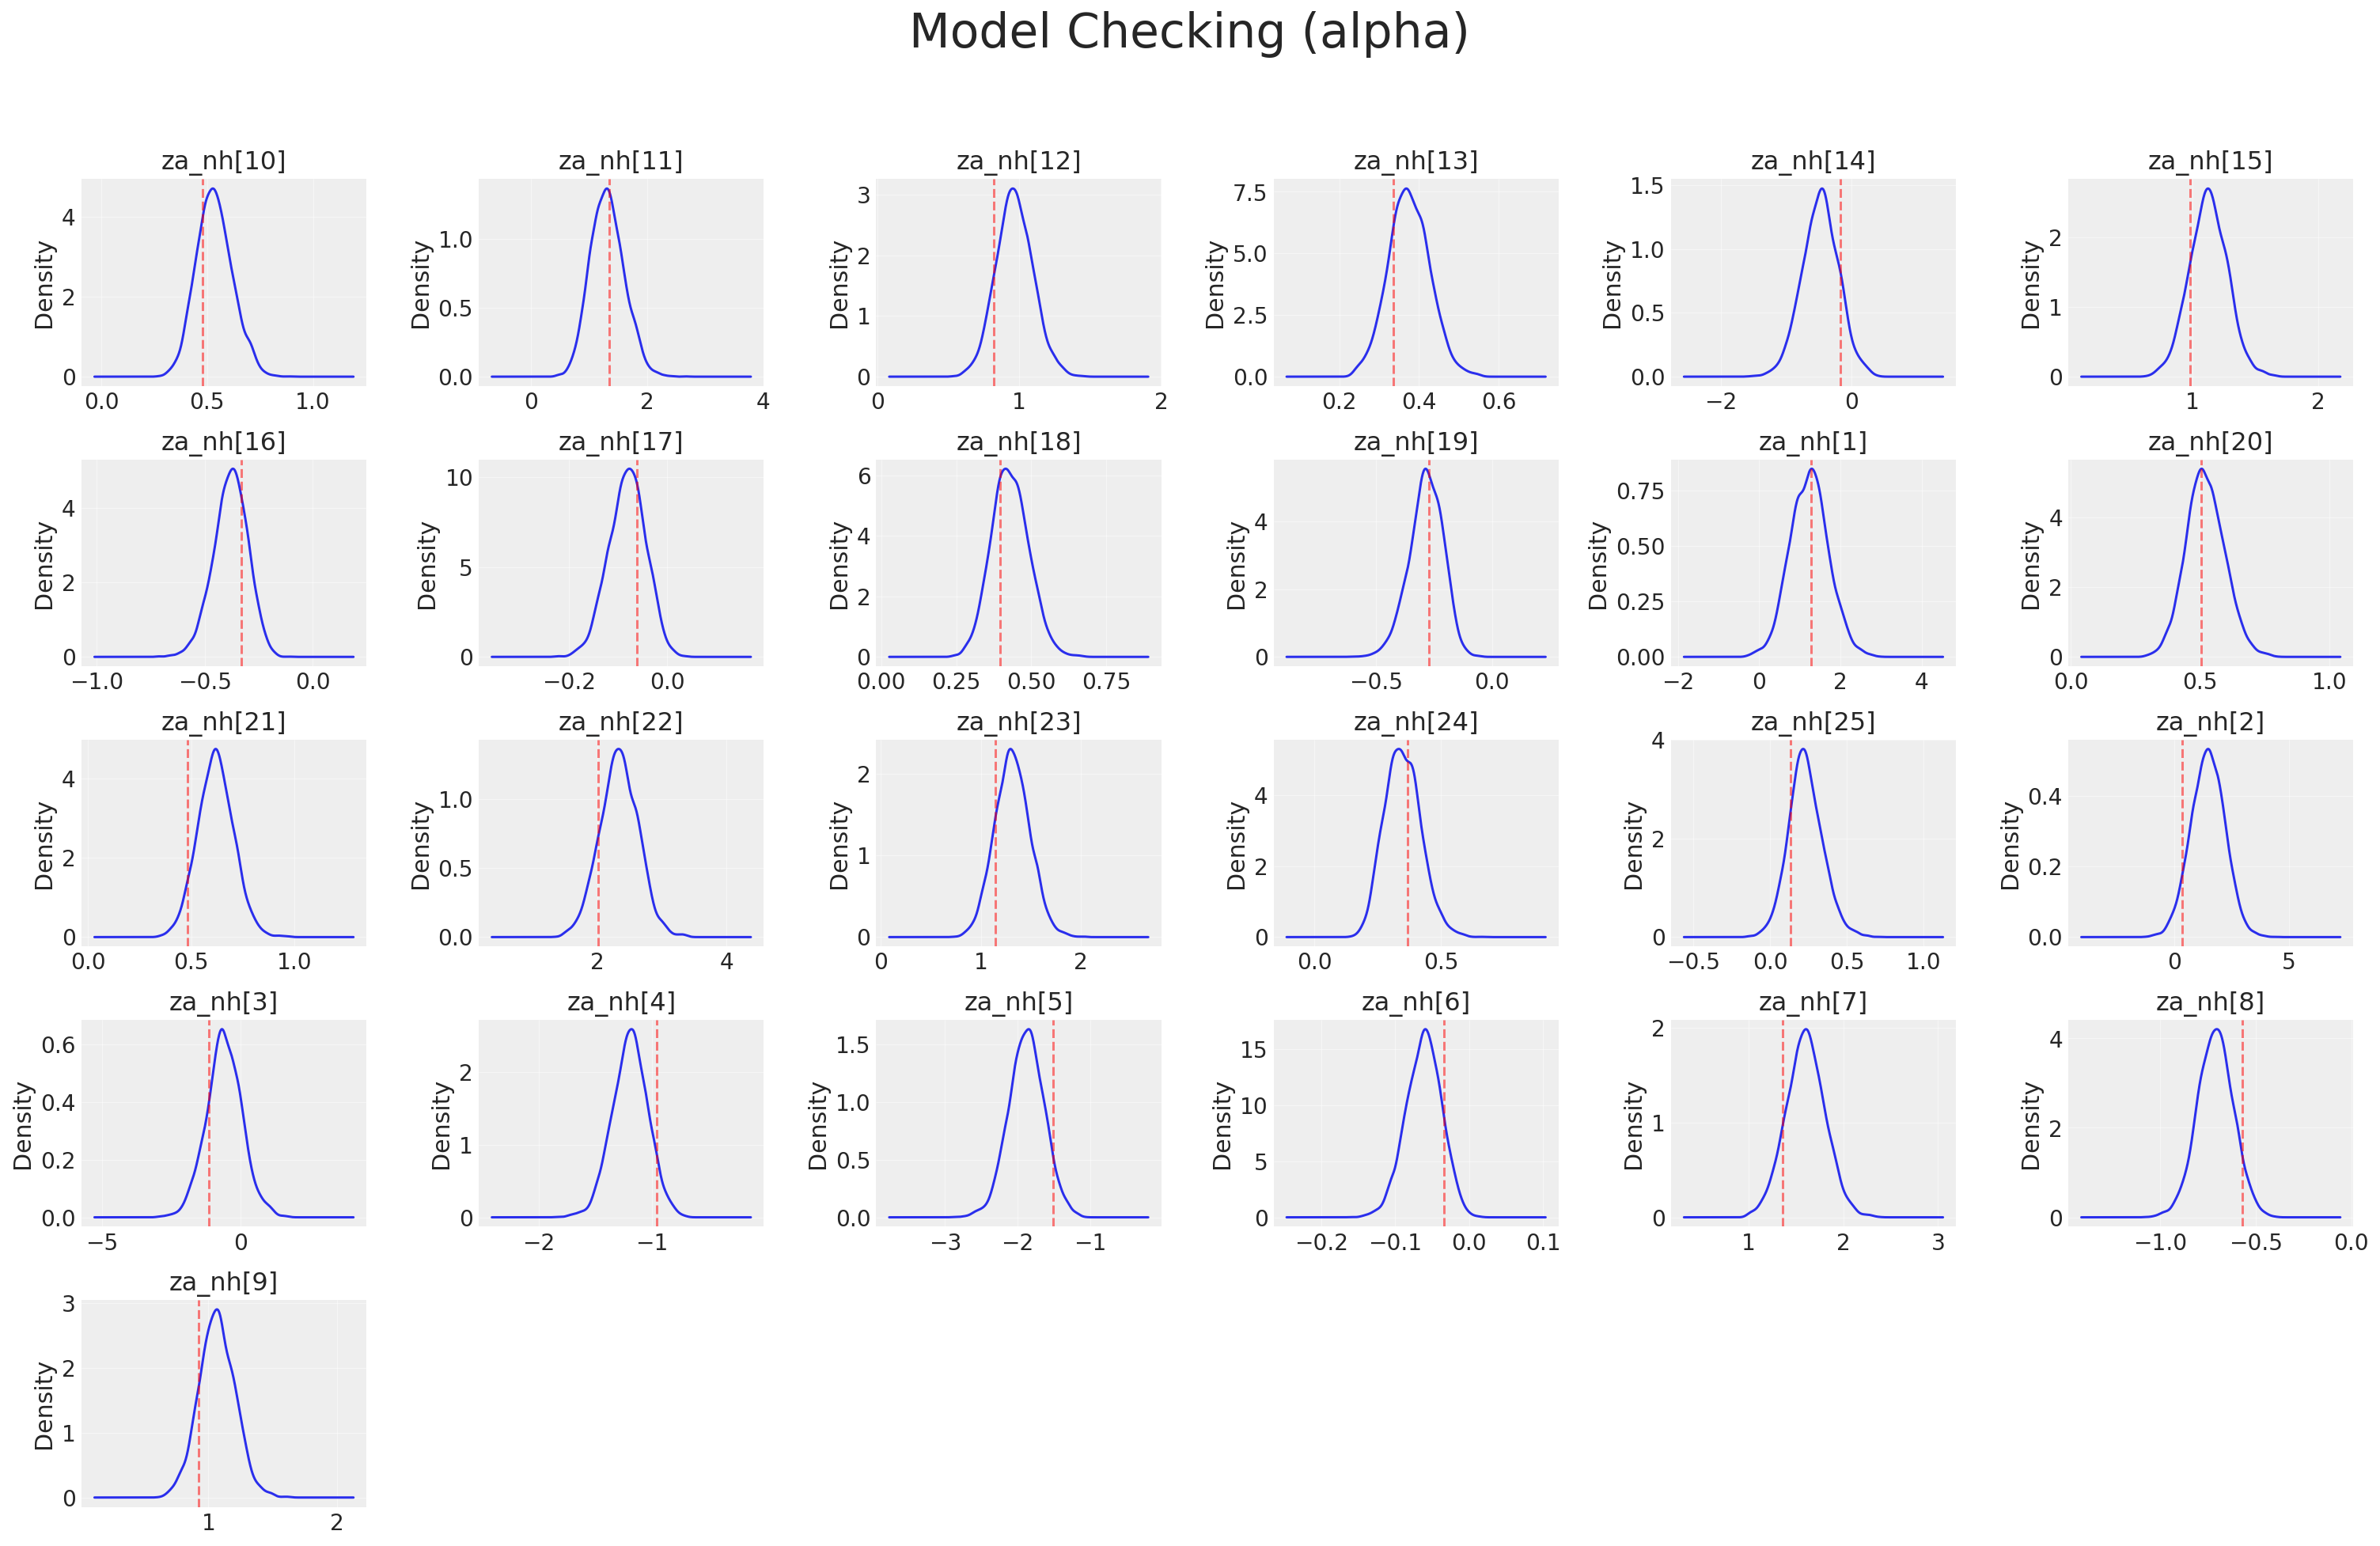

In [20]:
fake_fit = _nc_mls_df_check.filter(regex = 'za_nh')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (alpha)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=
                       False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


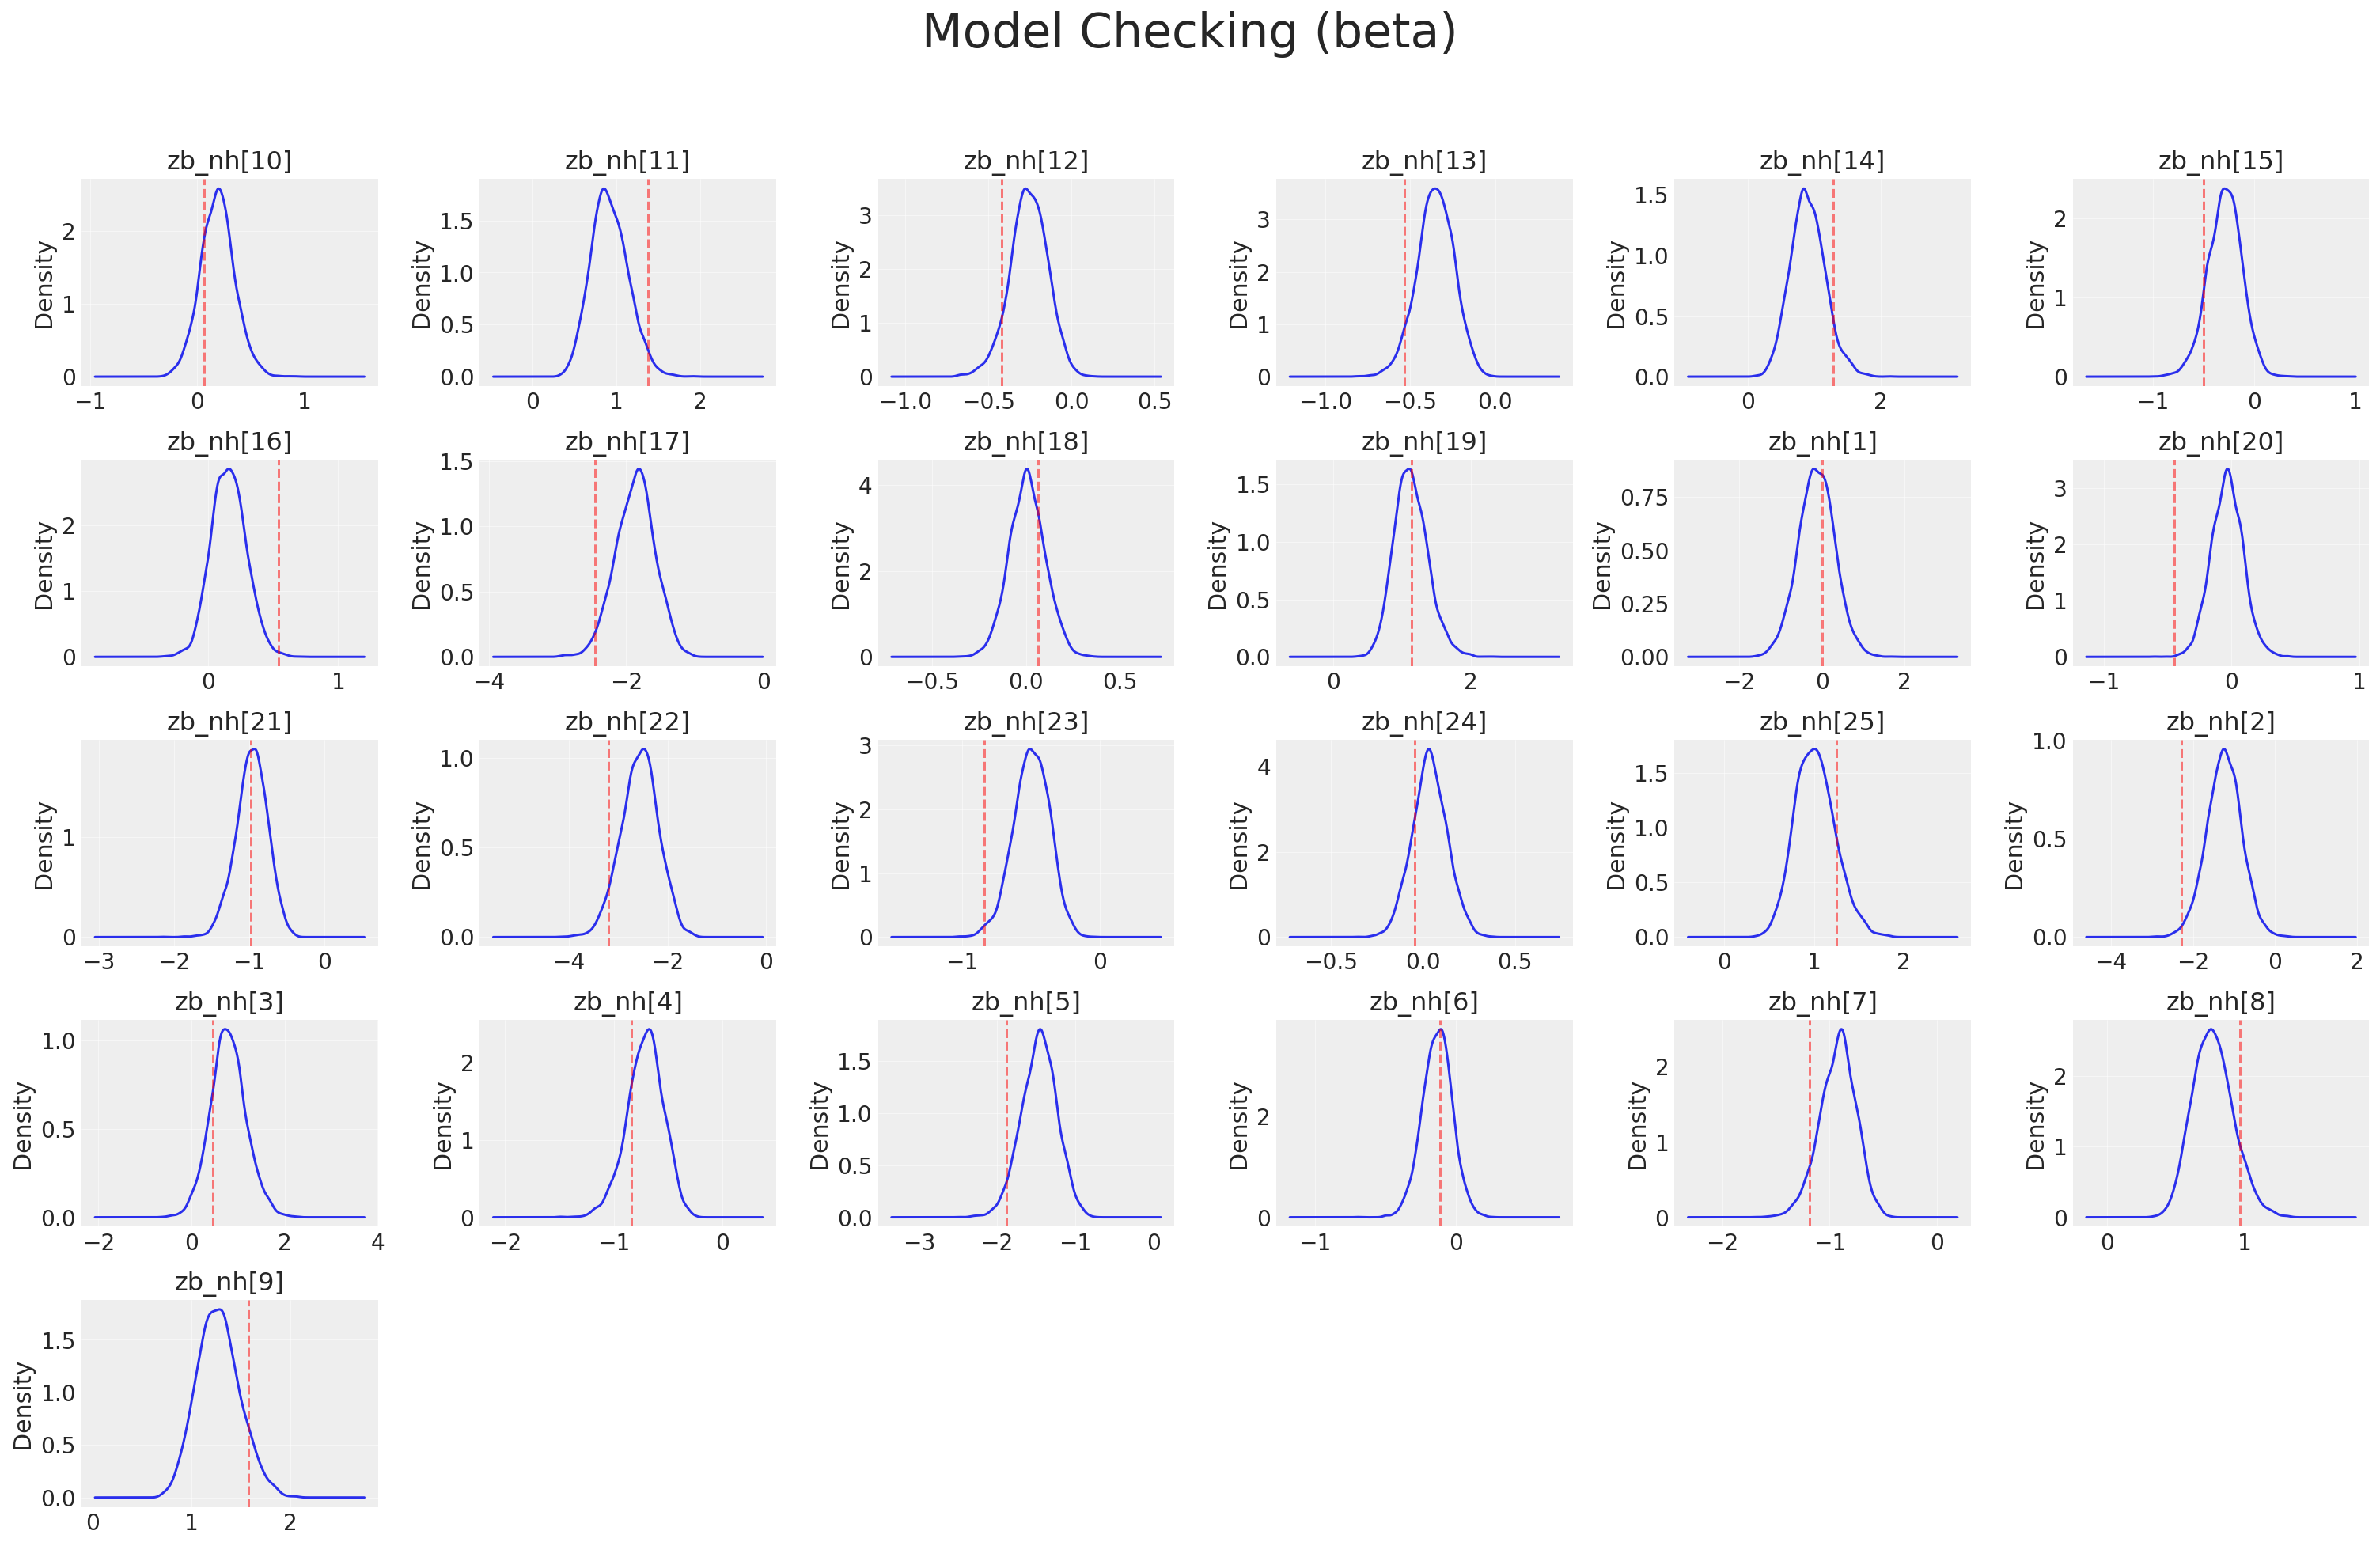

In [21]:
fake_fit = _nc_mls_df_check.filter(regex = 'zb_nh')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (beta)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


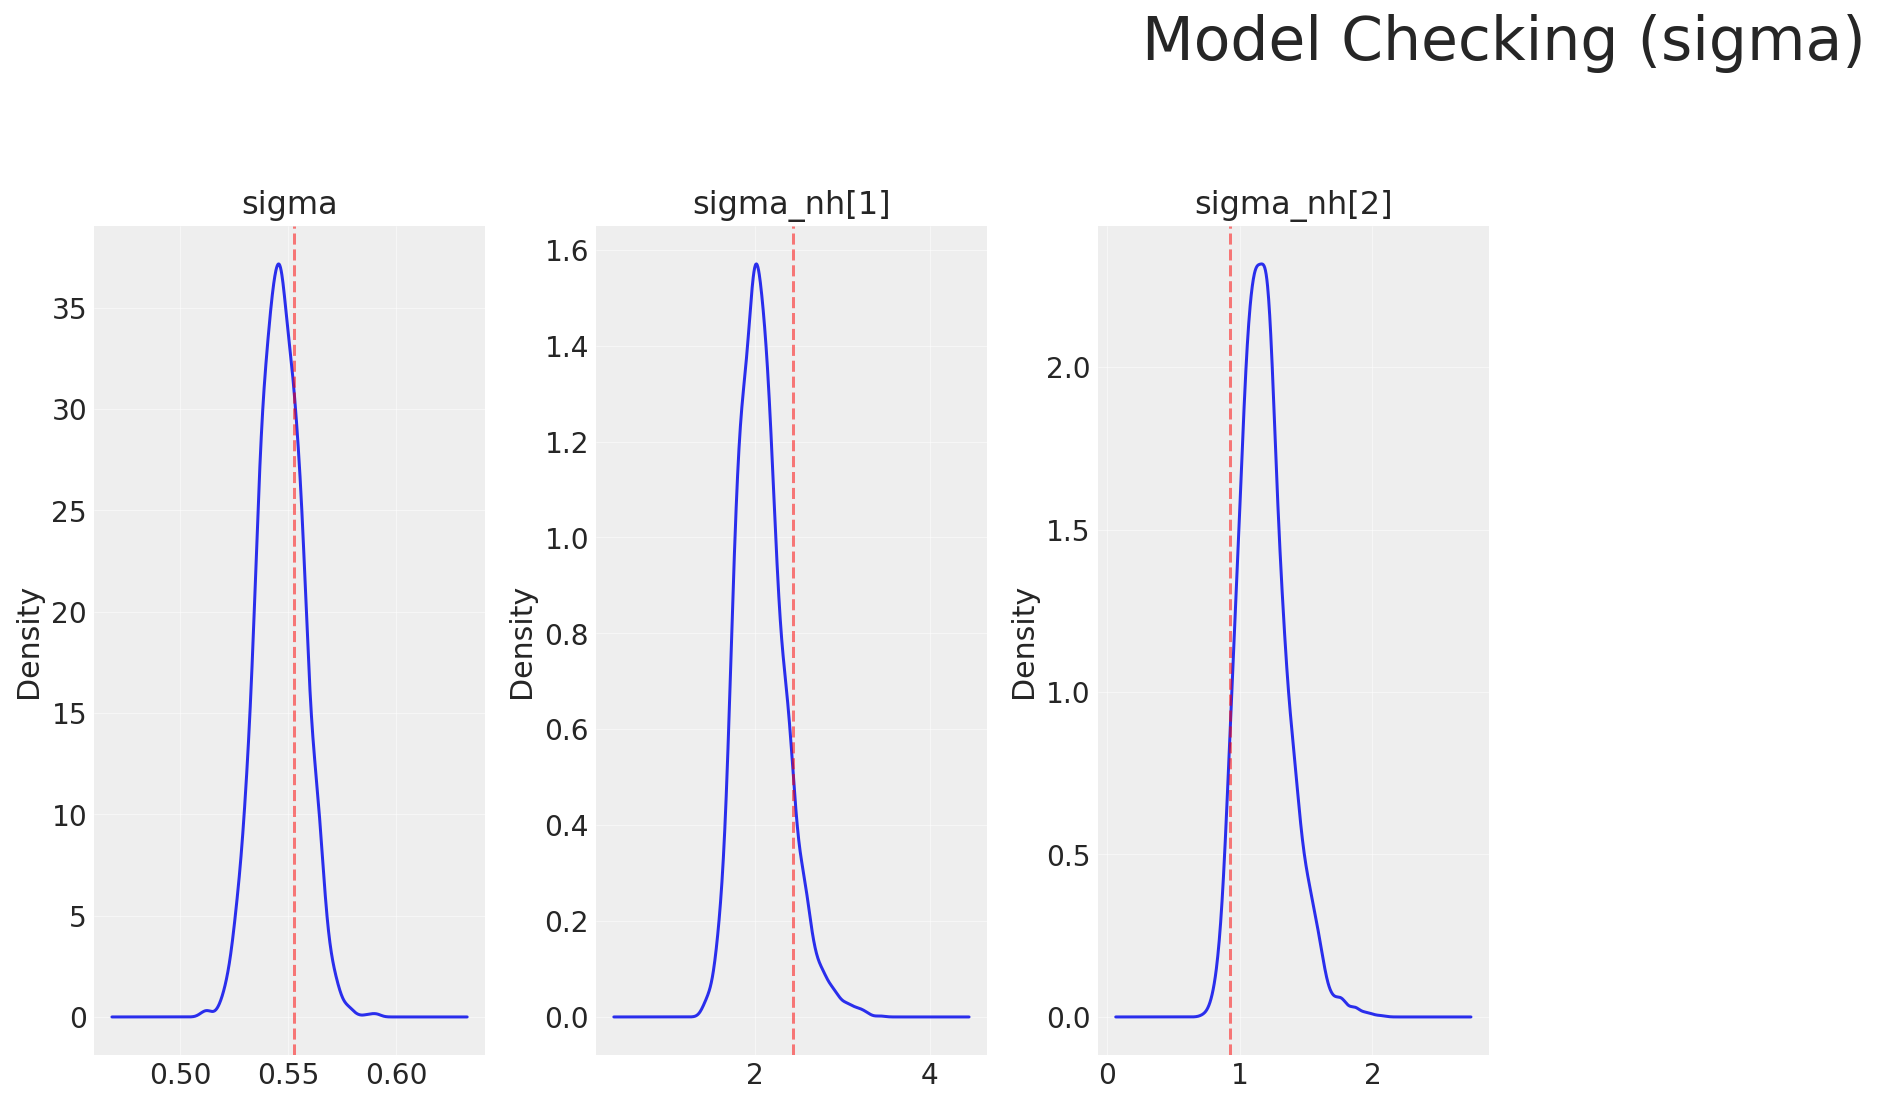

In [22]:
fake_fit = _nc_mls_df_check.filter(regex = 'sigma')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (sigma)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


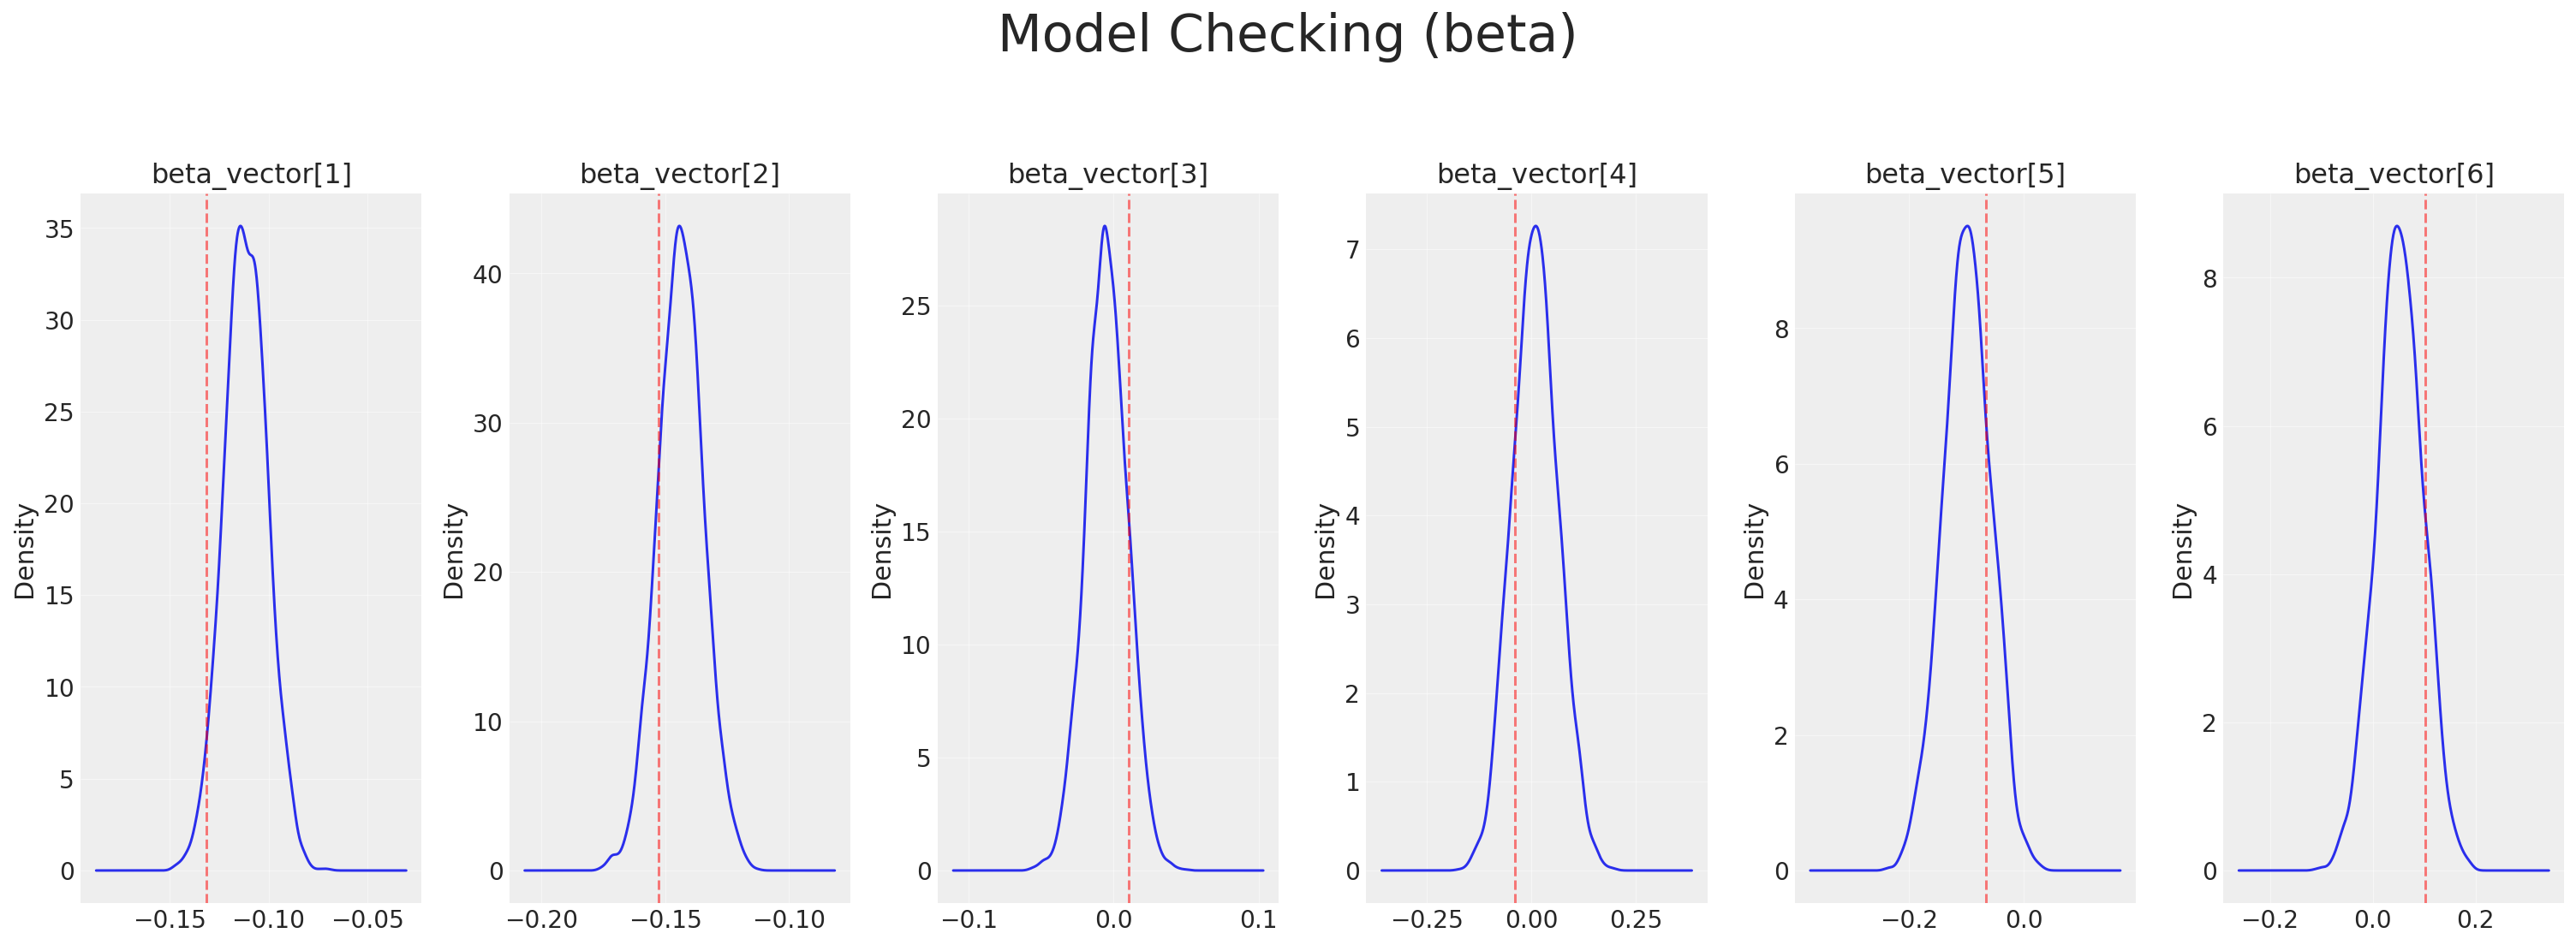

In [8]:
fake_fit = _nc_mls_df_check.filter(regex = 'beta_vector')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (beta)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

## Fit model on real data

In [9]:
nc_mls_data = dict(N = len(train),
                         N_test = len(test),
                         P = len(X.columns),
                         P_test = len(X_test.columns),
                         X = X,
                         X_test = X_test,
                         log_sales_price = train['log_sales_price_std'],
                         log_lot_area = train['log_lot_area_z'],
                         neighbourhood = train['neighbourhood'],
                         N_neighbourhood = len(train['Neighborhood'].unique()),
                         log_lot_area_test = test['log_lot_area_z'],
                         neighbourhood_test = test['neighbourhood'],
                         alpha_sd = alpha_sd,
                         beta_sd = beta_sd,
                         beta_vec_sd = beta_vec_sd,
                         sigma_sd = sigma_sd,
                         sigma_nh_sd = sigma_nh_sd,
                         Rho_eta =  Rho_eta,
                         run_estimation = 1)

# Fit model
fit_nc_mls = nc_multilevel_slopes.sampling(data=nc_mls_data)

nc_mls_az = az.from_pystan(
    posterior=fit_nc_mls,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_nc_mls_df = fit_nc_mls.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior predictive check

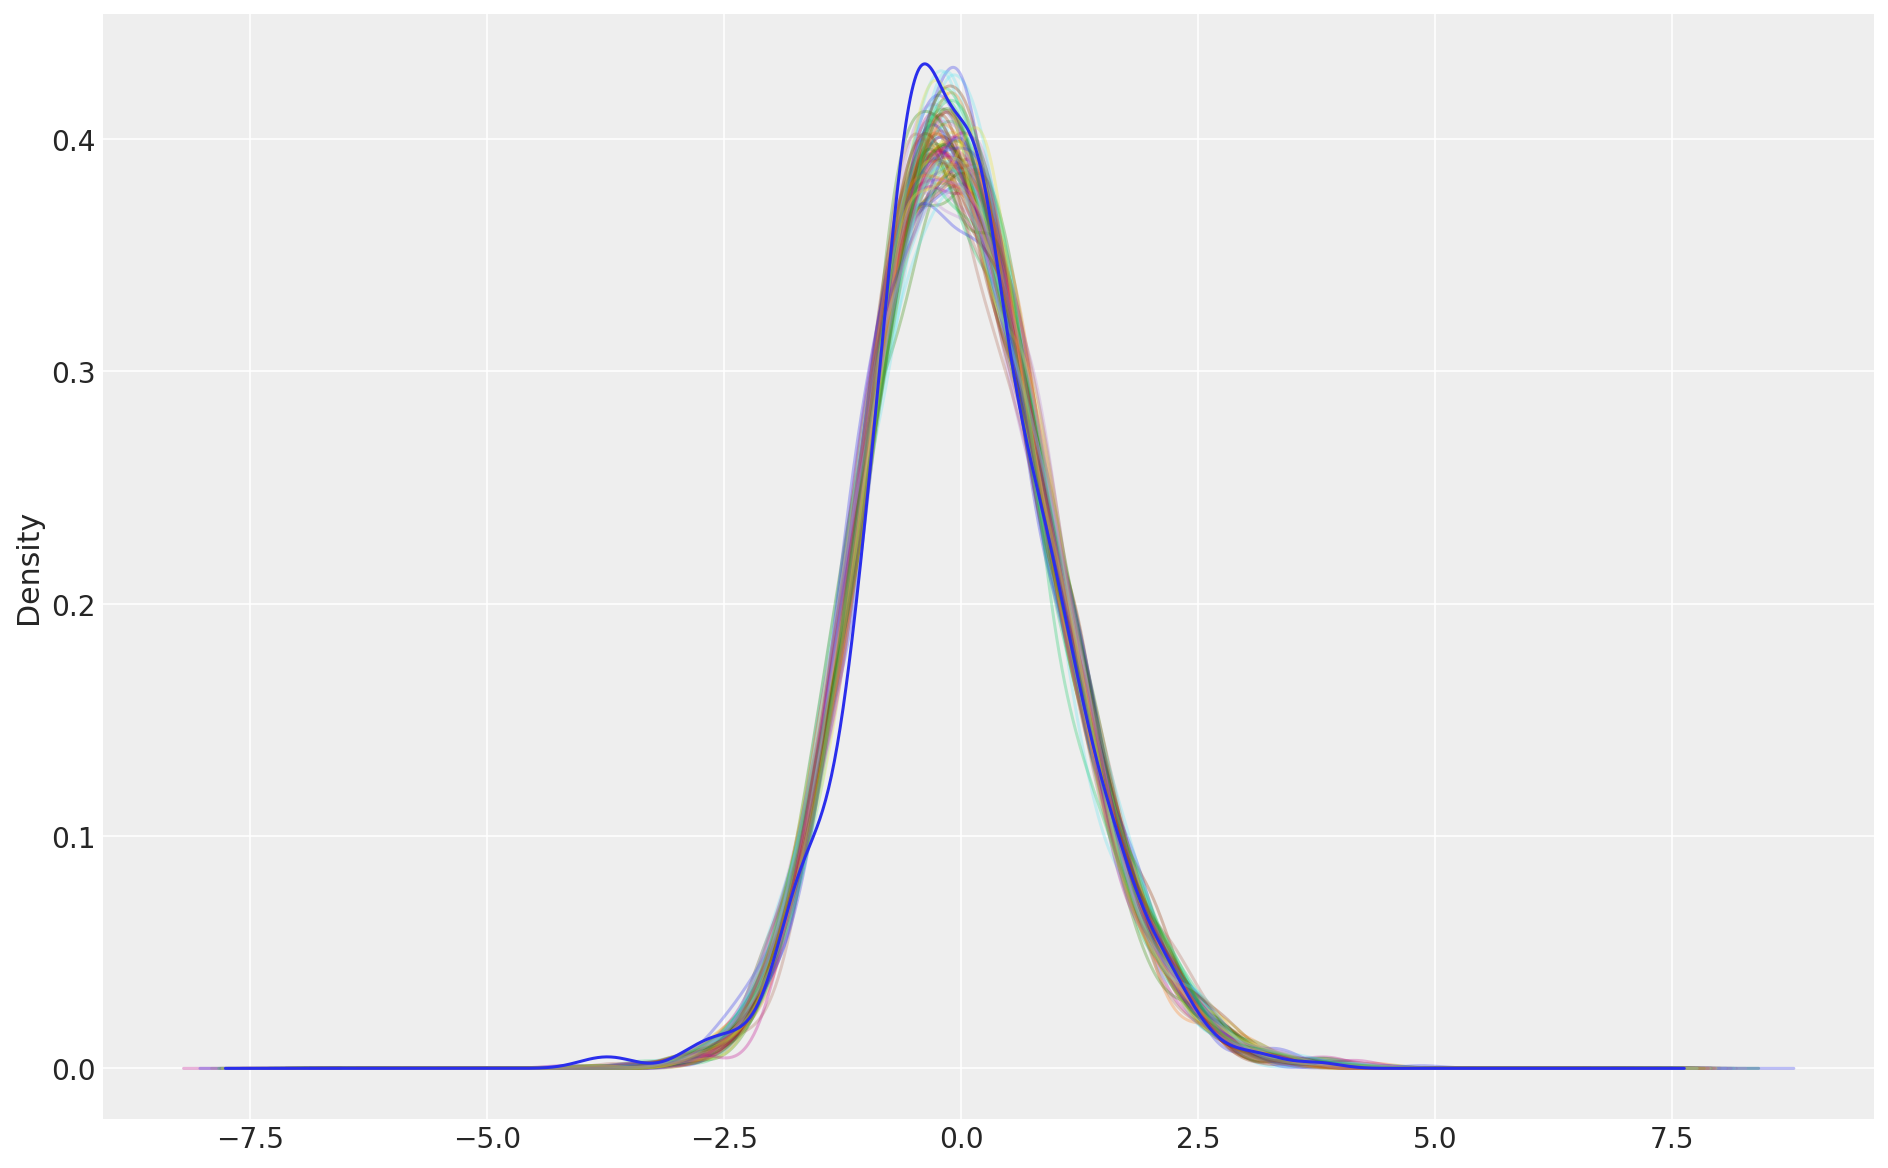

In [10]:
fig, axes = plt.subplots(1,1, figsize = (13,8))

fit_nc_mls_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

In [11]:
az.loo(nc_mls_az, pointwise = True, scale = 'log')

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo  -691.98    67.16
p_loo       68.90        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1457   99.8%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    2    0.1%

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


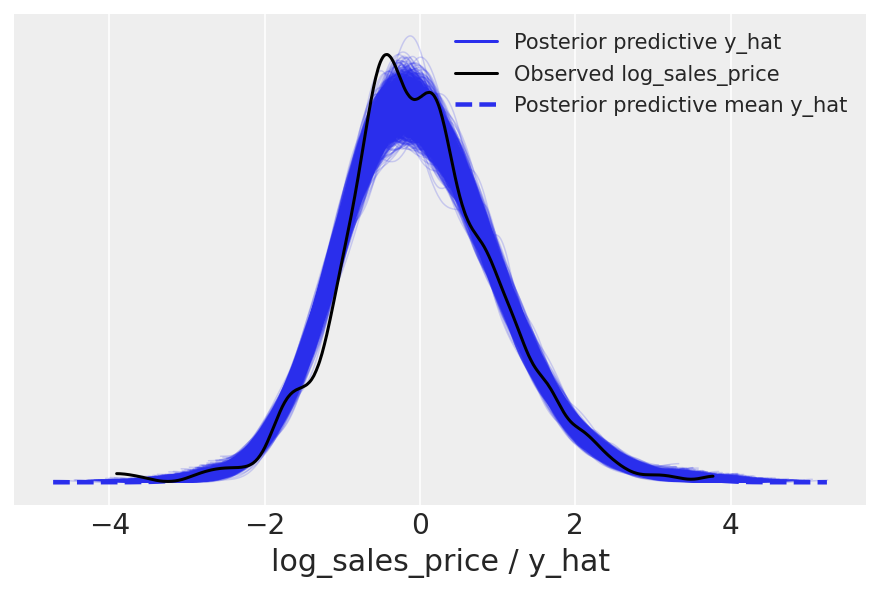

In [12]:
az.plot_ppc(data = nc_mls_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

(-0.1, 1.5)

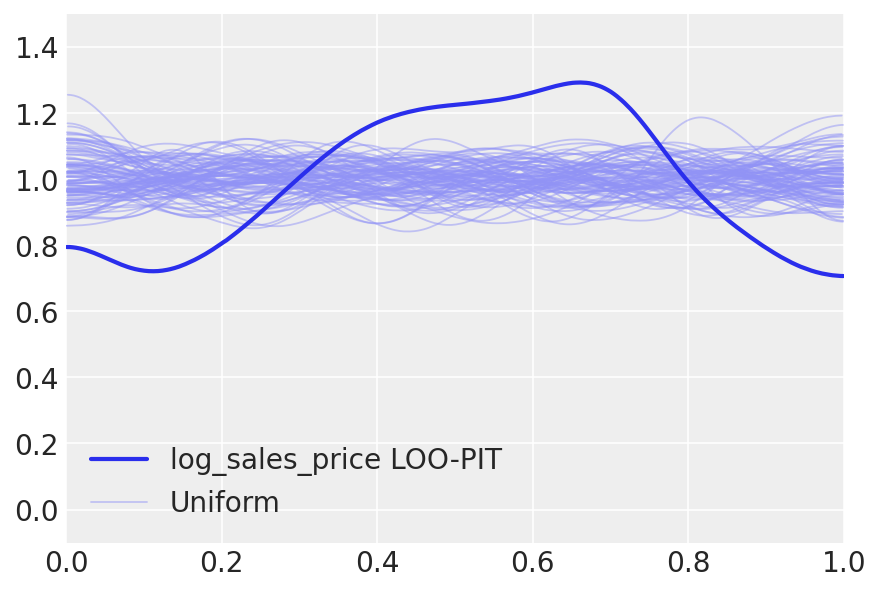

In [13]:
az.plot_loo_pit(idata=nc_mls_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

## Trace plots

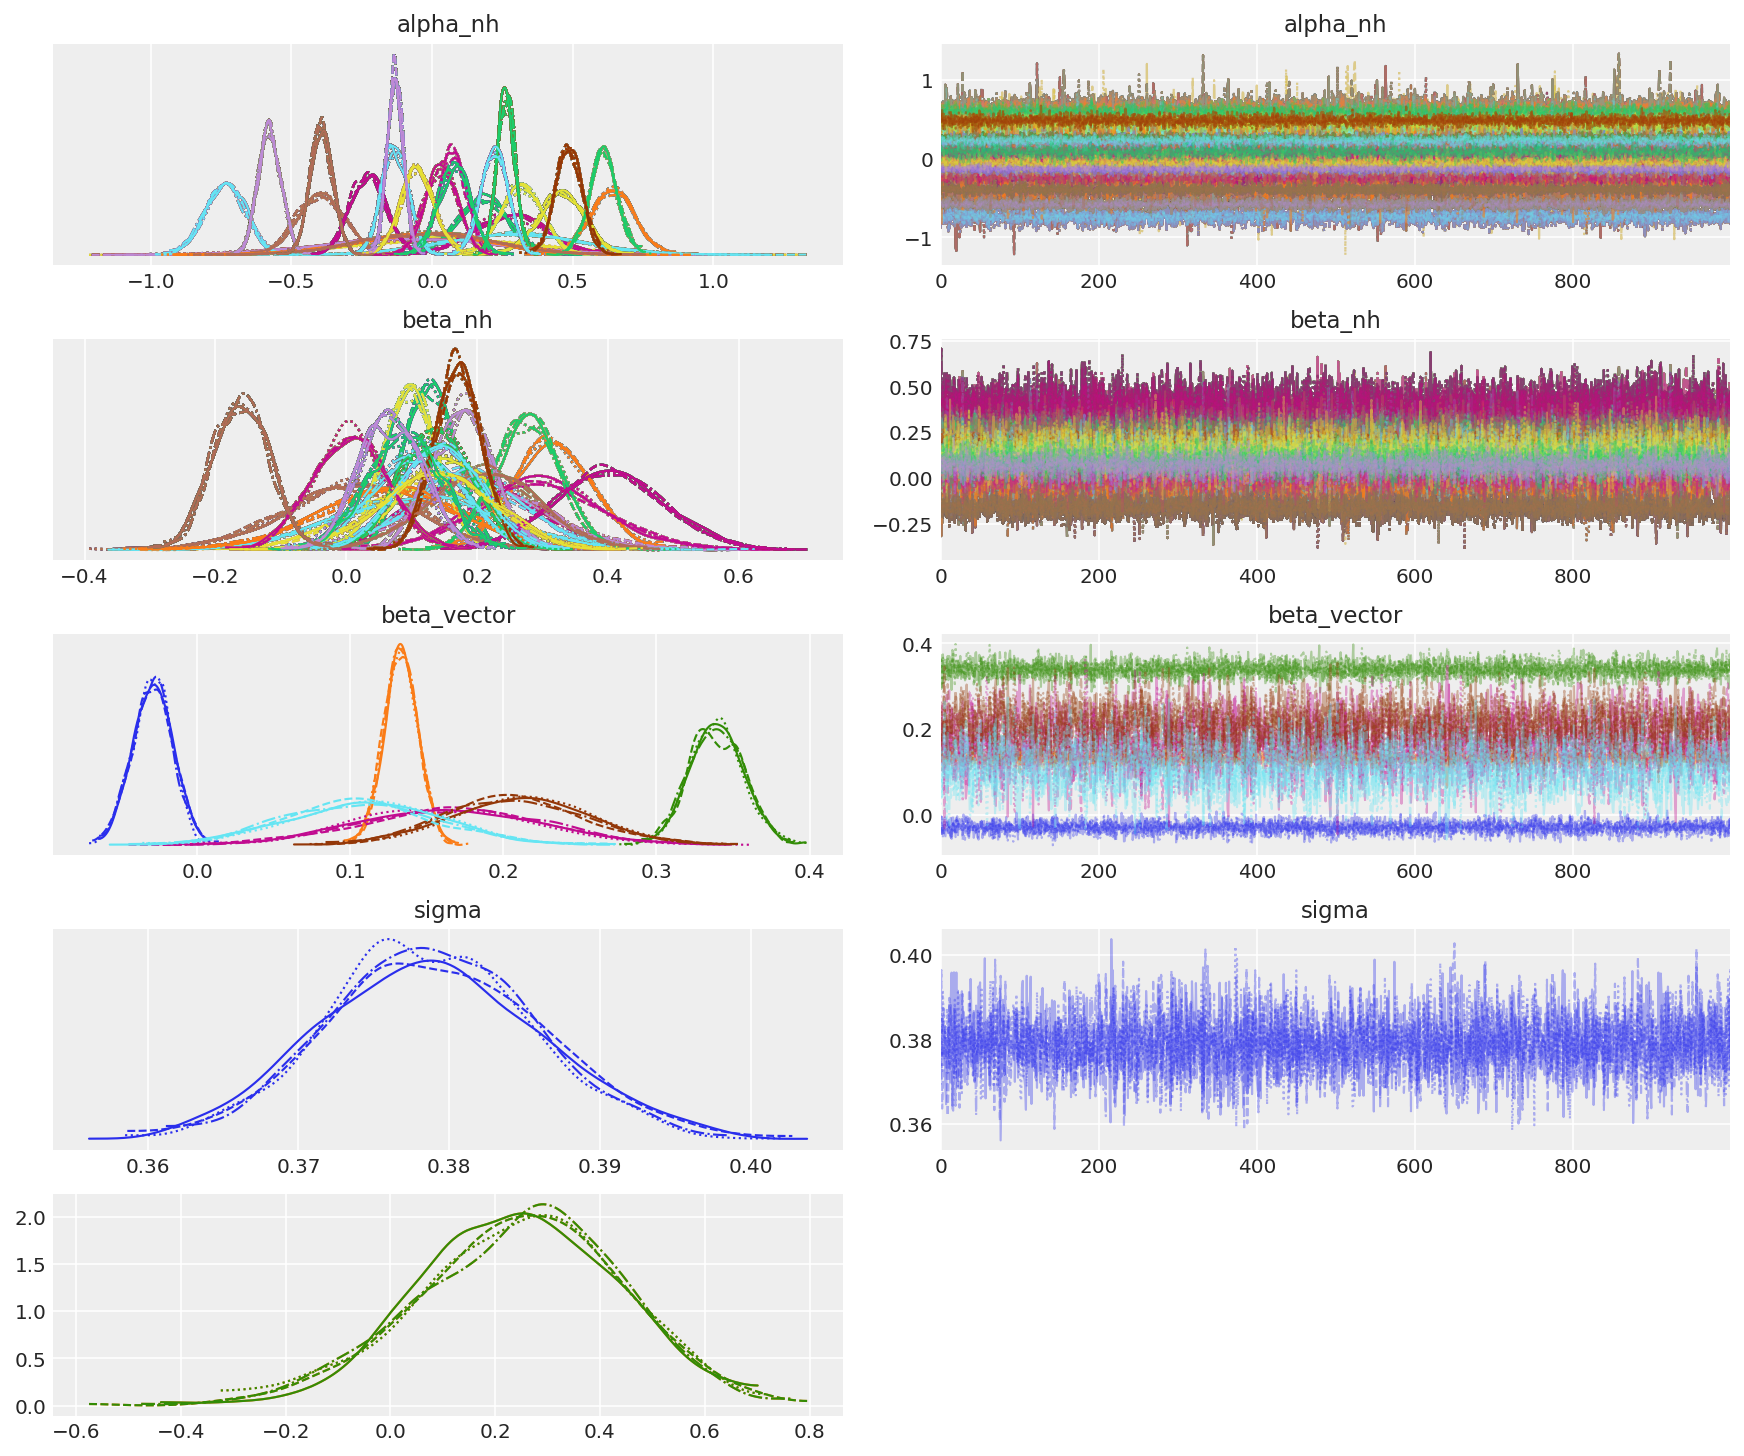

In [16]:
az.plot_trace(fit_nc_mls, var_names=["alpha_nh", "beta_nh", "beta_vector", "sigma", 'Rho'], compact = True);

## Posterior predictive checks on raw scale

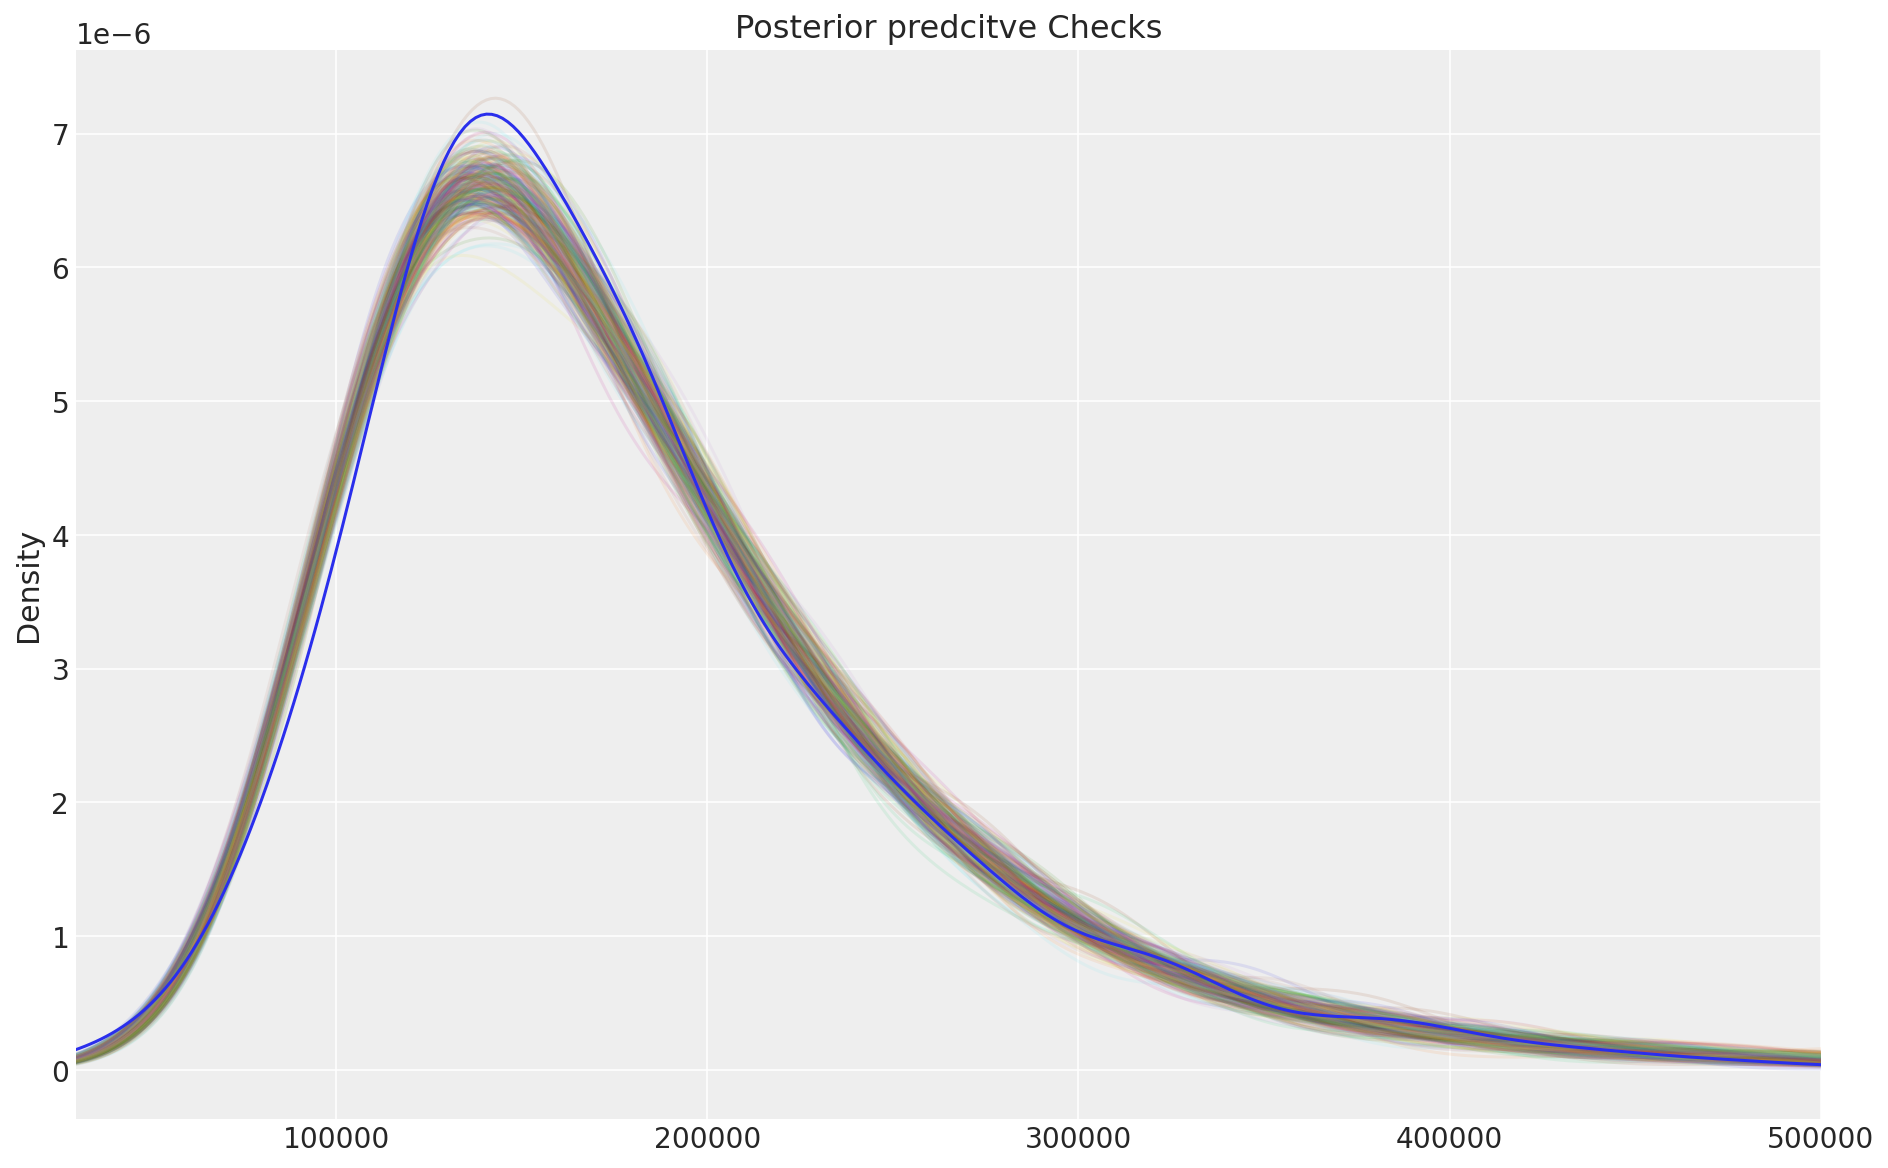

In [14]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_nc_mls_df.filter(regex = 'y_hat')*train['log_sales_price'].std()+train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [15]:
predictions = pd.DataFrame(np.exp((fit_nc_mls_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].std())+train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

nc_multilevel_slope_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

nc_multilevel_slope_csv.to_csv('../../data/submissions/nc_multilevel_slope_extra_features.csv', index = False)

In [17]:
%%sh
cd ../../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f nc_multilevel_slope_extra_features.csv -m "Partial pooling (multilevel slopes) with non centered parameterisation and extra features"


Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:07<00:00, 4.56kB/s]
